# Data augmentation

As the segmentation data is scarse, a trick to have more avaibable annotated data is to use data augmentation. Data augmentation is also a way of teaching certain invariance to your machine learning algorithm.

In particular, for biomedical data it is interesting to have these invariance:
- Translation
- rotation 
- Miror
- Out of focus or bluriness (due to the scanner for instance)
- Elastic deformation

## Loading the toy data

In [5]:
%matplotlib inline
### Useful plotting function
def plot_comparison(original, modified, modification):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,16), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax1.set_adjustable('box-forced')
    ax2.imshow(modified, cmap=plt.cm.gray)
    ax2.set_title(modification)
    ax2.axis('off')
    ax2.set_adjustable('box-forced')

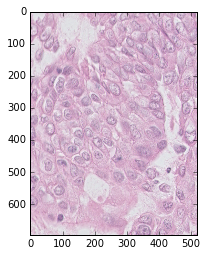

In [6]:
from skimage.io import imread
import matplotlib.pylab as plt


sample = imread('/home/naylor/Bureau/209.png')
## It has fourth (useless) component
sample = sample[:,:,0:3]

plt.imshow(sample)
plt.show()

## Translation invariance

Translation is the shifting of object’s location. If you know the shift in $(x,y)$ direction, let it be $(t_x,t_y)$, you can create the transformation matrix $\textbf{M}$ as follows:


$$M = \begin{bmatrix} 1 & 0 & t_x \\ 0 & 1 & t_y \end{bmatrix}$$

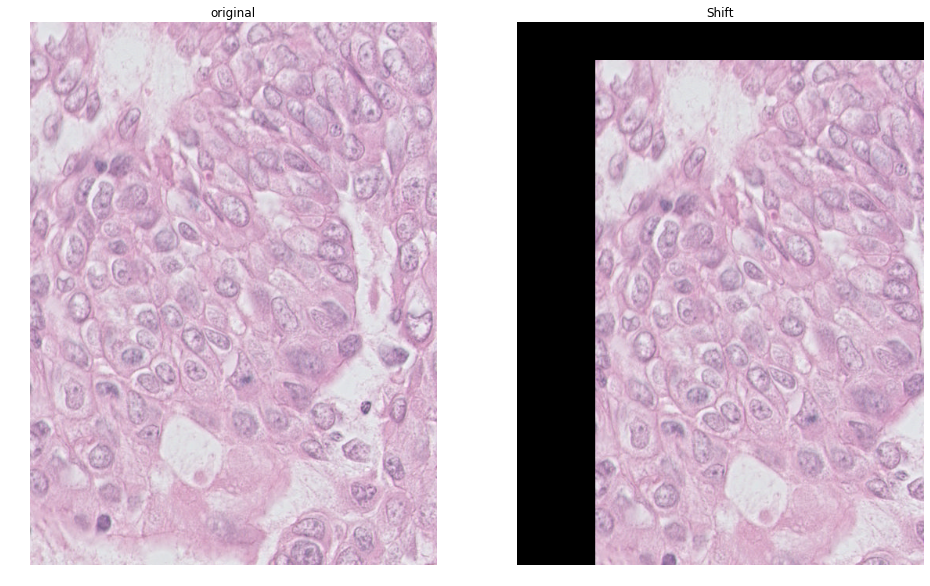

In [7]:
import cv2
import numpy as np

rows, cols, channels = sample.shape

M = np.float32([[1,0,100],[0,1,50]])
dst = cv2.warpAffine(sample,M,(cols,rows))
plot_comparison(sample, dst, "Shift")

# Rotation

Rotation of an image for an angle $\theta$ is achieved by the transformation matrix of the form

$$M = \begin{bmatrix} cos\theta & -sin\theta  \\ sin\theta & cos\theta \end{bmatrix}$$

But OpenCV provides scaled rotation with adjustable center of rotation so that you can rotate at any location you prefer. Modified transformation matrix is given by

$$\begin{bmatrix} \alpha & \beta & (1- \alpha ) \cdot center.x - \beta \cdot center.y \\ - \beta & \alpha & \beta \cdot center.x + (1- \alpha ) \cdot center.y \end{bmatrix}$$

where:

$$\begin{array}{l} \alpha = scale \cdot \cos \theta , \\ \beta = scale \cdot \sin \theta \end{array}$$

To find this transformation matrix, OpenCV provides a function, cv2.getRotationMatrix2D. Check below example which rotates the image by 90 degree with respect to center without any scaling.

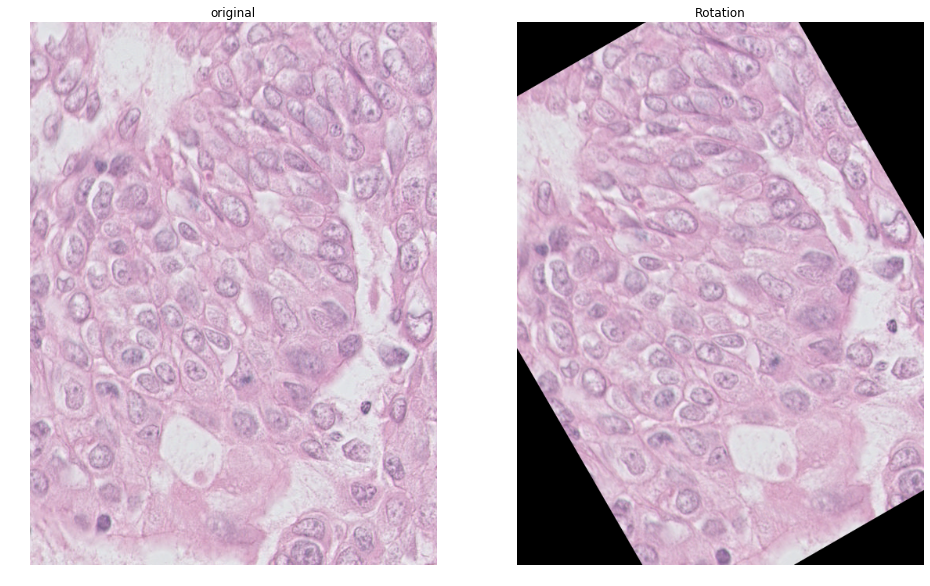

In [8]:
M = cv2.getRotationMatrix2D((cols/2,rows/2),30,1)
dst = cv2.warpAffine(sample,M,(cols,rows))

plot_comparison(sample, dst, "Rotation")

## Mirror

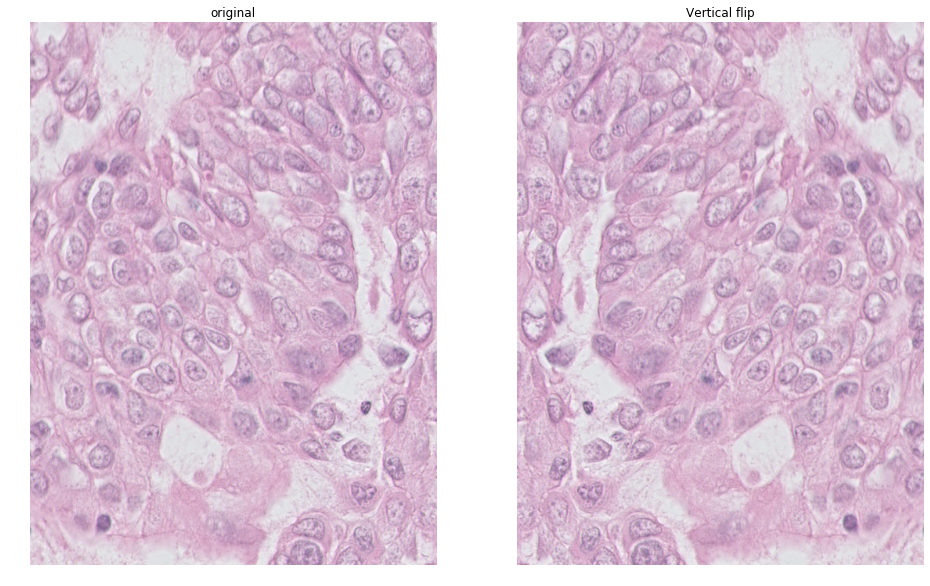

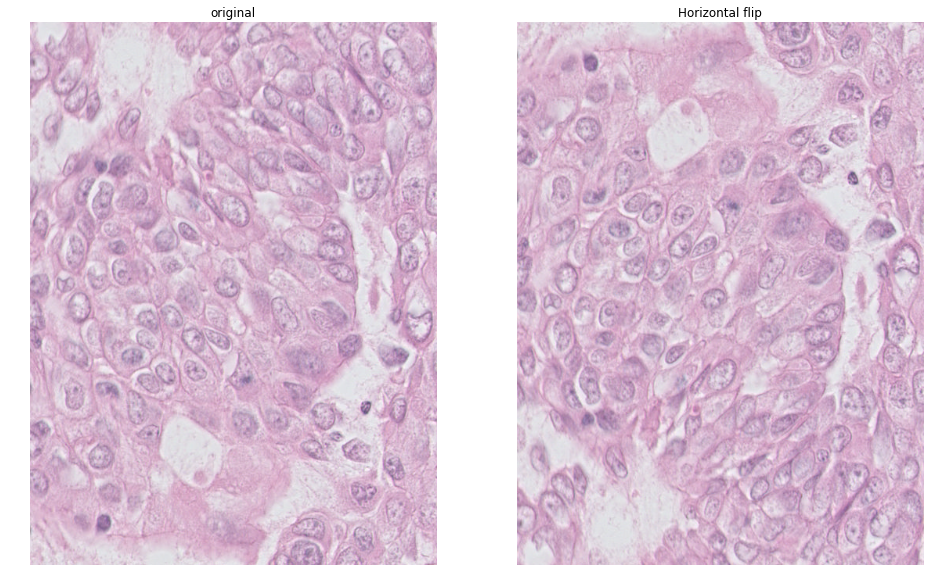

In [9]:
def flip_vertical(picture):
    result = picture.copy()
    height, width , channel= result.shape
    
    for x in range(0, width/2):   # Only process the half way
        for y in range(0, height):
        # swap pix and pix2
            #print [y, width  - x]
            result[y, width  - x - 1,  :] = picture[y, x, :]
            result[y, x, :] = picture[y, width - x - 1, :]
    return result

def flip_horizontal(picture):
    result = picture.copy()
    height, width , channel= result.shape
    
    for y in range(0, height/2):   # Only process the half way
        for x in range(0, width):
        # swap pix and pix2
            #print [y, width  - x]
            result[y, x,  :] = picture[height - 1 - y, x, :]
            result[height - 1 - y, x, :] = picture[y, x, :]
    return result

sample_vert = flip_vertical(sample)
sample_hori = flip_horizontal(sample)

plot_comparison(sample, sample_vert, "Vertical flip")
plot_comparison(sample, sample_hori, "Horizontal flip")

## Out of focus

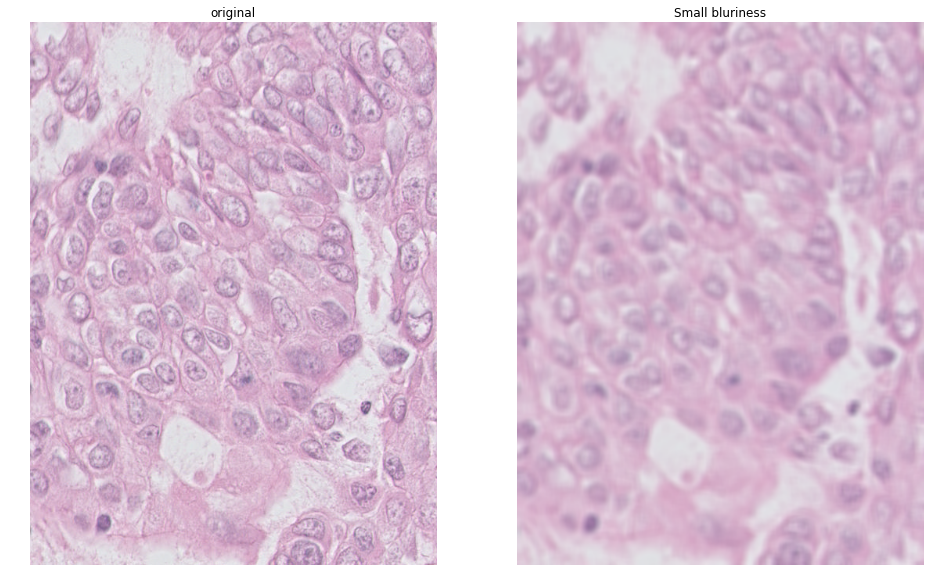

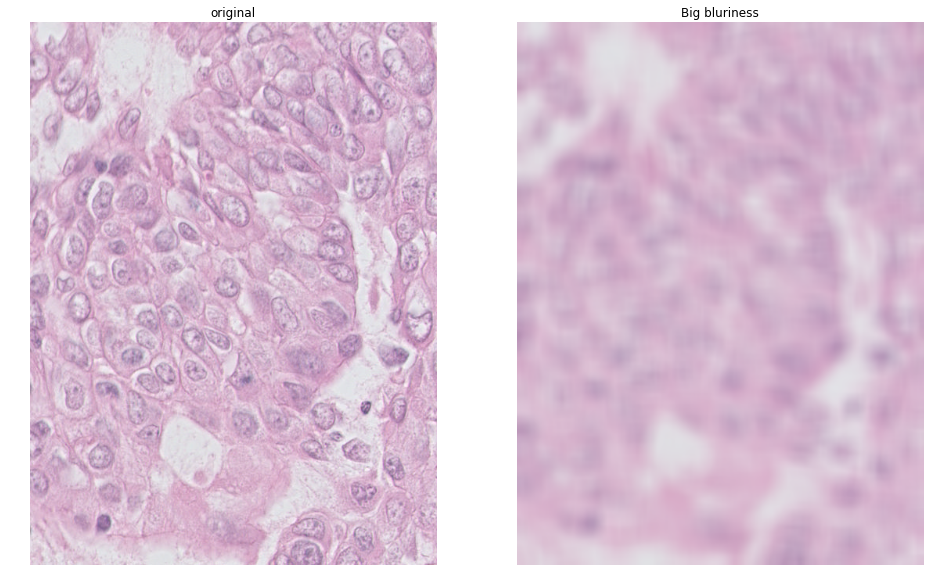

In [10]:
from scipy.ndimage.filters import gaussian_filter

blur = cv2.blur(sample,(10,10))
plot_comparison(sample, blur, "Small bluriness")

blur = cv2.blur(sample,(25,25))
plot_comparison(sample, blur, "Big bluriness")

# Elastic deformation

In [11]:
def grid(rows,cols,num_points):
    ### returns a grid in the form of a stacked array x is 0 and y is 1
    src_cols = np.linspace(0, cols, num_points)
    src_rows = np.linspace(0, rows, num_points)
    src_rows, src_cols = np.meshgrid(src_rows, src_cols)
    src = np.dstack([src_cols.flat, src_rows.flat])[0]
    return src


/home/naylor/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/naylor/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


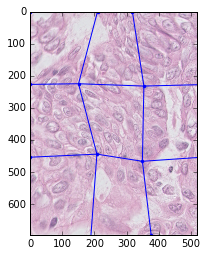

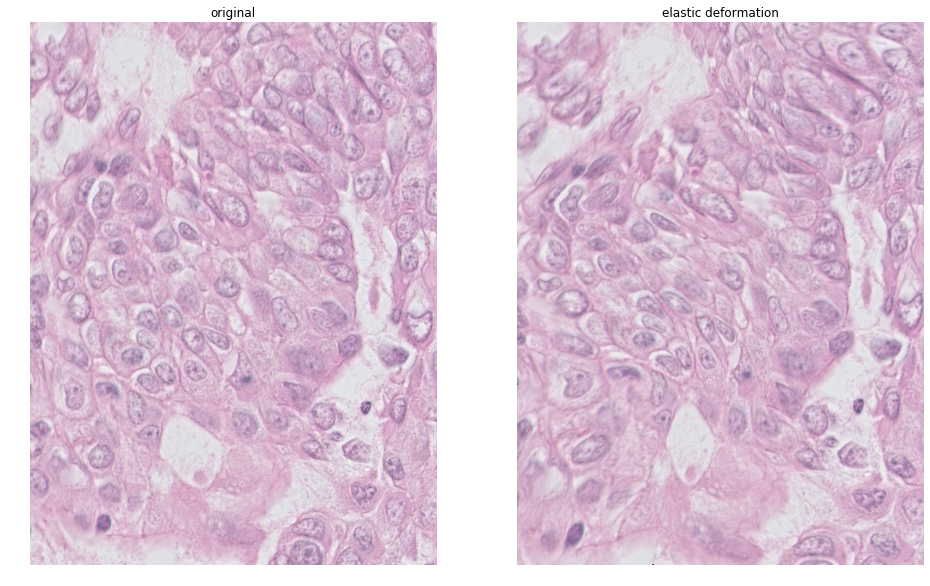

In [12]:
from skimage.transform import PiecewiseAffineTransform, warp

image = sample.copy()
rows, cols = image.shape[0], image.shape[1]

mu = 0
sigma = 30
num_points = 4

src = grid(rows, cols, num_points)
# add sinusoidal oscillation to row coordinates
dst_rows = src[:, 1] - sigma * np.random.randn(src.shape[0]) + mu
dst_cols = src[:, 0] - sigma * np.random.randn(src.shape[0]) + mu

## Delimiting points to the grid space
for point_ind in range(src.shape[0]):
    dst_rows[point_ind] = min(max(dst_rows[point_ind],0),rows)
    dst_cols[point_ind] = min(max(dst_cols[point_ind],0),cols)

#dst_rows *= 1.5
#dst_rows -= 1.5 * 50
dst = np.vstack([dst_cols, dst_rows]).T


tform = PiecewiseAffineTransform()
tform.estimate(src, dst)

#out_rows = image.shape[0] - 1.5 * 50
out_rows = rows
out_cols = cols
out = warp(image, tform, output_shape=(out_rows, out_cols))

fig, ax = plt.subplots()
ax.imshow(out)
ax.plot(tform.inverse(src)[:, 0], tform.inverse(src)[:, 1], '.b')
for i in range(num_points):
    
    hori = np.array([ j * num_points + i for j in range(num_points)])
    vert = np.array([ i * num_points + j for j in range(num_points)])
    #print "one"
    x_one = [max(el,0) for el in tform.inverse(src)[hori, 0]]
    for i in range(len(x_one)):
        if i>len(x_one)/2:
            if x_one[i] == 0:
                x_one[i] = cols
    x_two = [el for el in tform.inverse(src)[hori, 1] if el!=-1]
    x_two_mean = np.mean(x_two)
    x_two = [el if el!=-1 else x_two_mean for el in tform.inverse(src)[hori, 1]]
    
    #print tform.inverse(src)[hori, 0], tform.inverse(src)[hori, 1]
    #print "one bis"
    #print x_one, x_two
    #print "two"
    #print tform.inverse(src)[vert, 0], tform.inverse(src)[vert, 1]
    
    y_one = [max(el,0) for el in tform.inverse(src)[vert, 1]]
    for i in range(len(y_one)):
        if i>len(y_one)/2:
            if y_one[i] == 0:
                y_one[i] = rows
    y_two = [el for el in tform.inverse(src)[vert, 0] if el!=-1]
    y_two_mean = np.mean(y_two)
    y_two = [el if el!=-1 else y_two_mean for el in tform.inverse(src)[vert, 0]]
    
    
    #ax.plot(tform.inverse(src)[hori, 0], tform.inverse(src)[hori, 1], '-b')
    ax.plot(x_one, x_two, '-b')
    #ax.plot(tform.inverse(src)[vert, 0], tform.inverse(src)[vert, 1], '-b')
    ax.plot(y_two,y_one, '-b')
ax.axis((0, out_cols, out_rows, 0))
plt.show()
plot_comparison(sample,out,"elastic deformation")

# Having more data still...